In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="4"
# 检查 GPU 是否可用  
import torch
if torch.cuda.is_available():  
   print("GPU 可用")  
   # 获取 GPU 设备数量  
   num_gpus = torch.cuda.device_count()  
   print(f"共有{num_gpus}个 GPU 设备")
   # 获取 GPU 设备信息  
   for i in range(num_gpus):  
       print(f"设备{i}: {torch.cuda.get_device_properties(i)}")  
else:  
   print("GPU 不可用")  
import sys
# sys.path.append("/workspace/notebooks/")
# sys.path.append("/workspace/notebooks/FSS/")
import numpy as np
import matplotlib.pyplot as plt

GPU 可用
共有1个 GPU 设备
设备0: _CudaDeviceProperties(name='NVIDIA GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11011MB, multi_processor_count=68)


In [2]:
import sys
sys.path.append("../packages/autoqnn/")
import autoqnn

In [3]:
# sys.path.append("../packages/BeYourOwnTeacher/models")
sys.path.append("../packages")
# from BeYourOwnTeacher.models.resnet import multi_resnet18_kd
from sdn_resnet import resnet18 as sdn_mtl_resnet18

# DSN ResNet18 on Cifar100

DSN的意思就是，使用和SDN完全一样的模型，但是训练呢不加KD进行知识蒸馏，所以DSN本身是没有额外的知识蒸馏的监督部分，只有损失部分，正好可以用于写train和test函数

In [4]:
model = sdn_mtl_resnet18(num_classes=100)
model = model.cuda()
model_name = "dsn_mtl_resnet18"

In [5]:
from autoqnn import datasets
torch_weights_path=f"{os.environ['HOME']}/models/torch/weights"
data_root="~/datasets/cifar100"
dataset_name = 'cifar100'
trainloader,testloader,classes = datasets.cifar.get_cifar_dataloader(
    root=data_root,dataset=dataset_name,autoaugment=True)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
from torch import nn,optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
epochs=200
loss_coefficient=0.3
feature_loss_coefficient=0.03
autoaugment=True
temperature=3.0
batchsize=500
init_lr=0.1
weight_decay=5e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=init_lr, weight_decay=weight_decay, momentum=0.9)
init = False

# Define KD Loss
def CrossEntropy(outputs, targets):
    log_softmax_outputs = F.log_softmax(outputs/temperature, dim=1)
    softmax_targets = F.softmax(targets/temperature, dim=1)
    return -(log_softmax_outputs * softmax_targets).sum(dim=1).mean()

In [7]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
# Training and Testing
import sys
import time
# 将程序的输出重定向到文件  
file_path = f'./training_logs/{model_name}-on-cifar100-lr-{init_lr}-wd-{weight_decay}-epoch-{epochs}.txt'  
sys.stdout = open(file_path, 'w')

best_acc = 0
batch_time = AverageMeter()
data_time = AverageMeter()
for epoch in range(epochs):
    correct = [0 for _ in range(5)]
    predicted = [0 for _ in range(5)]
    if epoch in [epochs // 3, epochs * 2 // 3, epochs - 10]:
        for param_group in optimizer.param_groups:
            param_group['lr'] /= 10
    model.train()
    sum_loss, total = 0.0, 0.0
    end_time = time.time()
    for i, data in enumerate(trainloader, 0):
        data_time.update(time.time() - end_time)
        length = len(trainloader)
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs, outputs_feature = model(inputs)
        ensemble = sum(outputs[:-1])/len(outputs)
        ensemble.detach_()

        #   compute loss
        loss = torch.FloatTensor([0.]).to(device)

        #   for deepest classifier
        loss += criterion(outputs[0], labels)

        #   for shallow classifiers
        for index in range(1, len(outputs)):
            loss += criterion(outputs[index], labels)

        sum_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_time.update(time.time() - end_time)
        end_time = time.time()
        
        total += float(labels.size(0))
        outputs.append(ensemble)

        for classifier_index in range(len(outputs)):
            _, predicted[classifier_index] = torch.max(outputs[classifier_index].data, 1)
            correct[classifier_index] += float(predicted[classifier_index].eq(labels.data).cpu().sum())
        print('[epoch:%d, iter:%d] Loss: %.03f | Acc: 4/4: %.2f%% 3/4: %.2f%% 2/4: %.2f%%  1/4: %.2f%%'
              ' Ensemble: %.2f%% | DataTime: %.4f(%.4f)s BatchTime: %.4f(%.4f)s' % (epoch + 1, (i + 1 + epoch * length), sum_loss / (i + 1),
                                      100 * correct[0] / total, 100 * correct[1] / total,
                                      100 * correct[2] / total, 100 * correct[3] / total,
                                      100 * correct[4] / total, 
                                      data_time.val,data_time.avg,batch_time.val,batch_time.avg))

    print("Waiting Test!")
    with torch.no_grad():
        correct = [0 for _ in range(5)]
        predicted = [0 for _ in range(5)]
        total = 0.0
        for data in testloader:
            model.eval()
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs, outputs_feature = model(images)
            ensemble = sum(outputs) / len(outputs)
            outputs.append(ensemble)
            for classifier_index in range(len(outputs)):
                _, predicted[classifier_index] = torch.max(outputs[classifier_index].data, 1)
                correct[classifier_index] += float(predicted[classifier_index].eq(labels.data).cpu().sum())
            total += float(labels.size(0))

        print('Test Set AccuracyAcc: 4/4: %.4f%% 3/4: %.4f%% 2/4: %.4f%%  1/4: %.4f%%'
              ' Ensemble: %.4f%%' % (100 * correct[0] / total, 100 * correct[1] / total,
                                     100 * correct[2] / total, 100 * correct[3] / total,
                                     100 * correct[4] / total))
        if correct[4] / total > best_acc:
            best_acc = correct[4]/total
            print("Best Accuracy Updated: ", best_acc * 100)
            save_file_name = f"./models/{model_name}-cifar100-top1.pth"
            torch.save(model.state_dict(), save_file_name)

print("Training Finished, Total EPOCH=%d, Best Accuracy=%.3f" % (epochs, best_acc))

# Save the trained parameters to disk
# best_loss = np.min(val_loss)
# best_metric = np.max(val_metrics）
save_file_name = f"./models/{model_name}-cifar100-top1-{best_acc}.pth"
torch.save(model.state_dict(),save_file_name)
print(f"save model weight to {save_file_name}")
# 关闭文件  
sys.stdout.close()  

In [ ]:
import sys
# 将程序的输出重定向到文件  
file_path = f'./training_logs/{model_name}-on-cifar100-lr-{lr}-wd-{weight_decay}-epoch-{epochs}.txt'  
sys.stdout = open(file_path, 'w')

# 要输出的内容  
for epoch in range(epochs):
    # adjust_learning_rate(optim,epoch,steps=[30,60])
    print(f"#################epoch {epoch+1}#################")
    print("lr=%.6f \n"%(optim.param_groups[0]['lr']))
    batch_time[epoch],data_time[epoch],loss[epoch],metric=autoqnn.core.train(trainloader,model,criterion,optim,
                       metric_meds=[autoqnn.core.top1],epoch=epoch)
    metrics[epoch]=metric[0].item()
    
    print()
    val_loss[epoch],metric = autoqnn.core.validate(testloader,model,criterion,
                      metric_meds=[autoqnn.core.top1],
                      print_freq=100)
    val_metrics[epoch] = metric[0].item()
    lr_scheduler.step()

# Save the trained parameters to disk
best_loss = np.min(val_loss)
best_metric = np.max(val_metrics）
save_file_name = f"./models/resnet18-cifar100-loss-{best_loss}-top1-{best_metric}.pth"
torch.save(model.state_dict(),save_file_name)
print(f"save model weight to {save_file_name}")
# 关闭文件  
sys.stdout.close()  

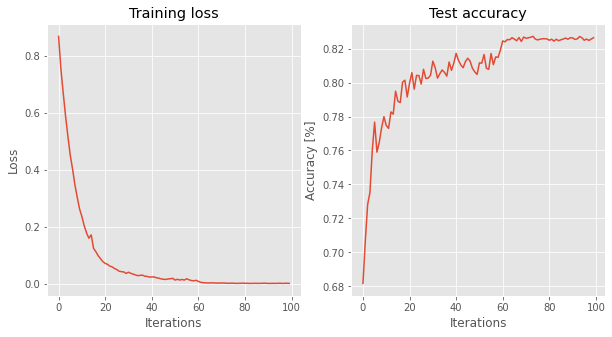

In [16]:
# draw the training curve
from train_utils import display_loss_plot
plt.style.use("ggplot")
plt.figure(figsize=(10,5))
# Plot training loss over epochs
loss_per_epoch = [np.mean(loss_per_epoch) for loss_per_epoch in running_loss]
plt.subplot(1,2,1)
display_loss_plot(loss_per_epoch)
# Plot test accuracy over epochs
acc_per_epoch = [np.mean(acc_per_epoch) for acc_per_epoch in running_test_acc]
plt.subplot(1,2,2)
display_loss_plot(acc_per_epoch, title="Test accuracy", ylabel="Accuracy [%]")
plt.show()

In [8]:
# Save the trained parameters to disk
torch.save(model.state_dict(), 
    "/workspace/notebooks/FSS/models/resnet18-cifar100-SDN-66.14-71.95-76.54-76.82.pth")